Figure 3: Shock predicting cell co-firing stifled by ANI administration

In [31]:
import scipy.stats as s
import numpy as np
import matplotlib.pyplot as plt
from os import path
import seaborn as sns
import pandas as pd
import scipy.io as sio
import pingouin as pg

# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))
%load_ext autoreload
%autoreload 2

import eraser_reference as err
import er_plot_functions as er
from plotting import Fig, pretty_plot, FigMirror
import placefield_stability as pfs
import Placefields as pf
import discrimination as discr
import ca_traces as trc
import freezing_analysis as fa
from plotting import Fig, pretty_plot, FigMirror
from helpers import contiguous_regions
import covariance_analysis as cova

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Set up Figure 3 and S6 (example freeze-tuned rasters) and maybe S7 (ensemble analysis)

Plot #1: Example motion trace with cell activity overlaid.  Ideally this would show two neurons that aren't tuned together before shock and then activate together after shock.

Plot #2: Example freeze-tuned cell rasters from each group?

[8.5 6.5]
[8.5 6.5]


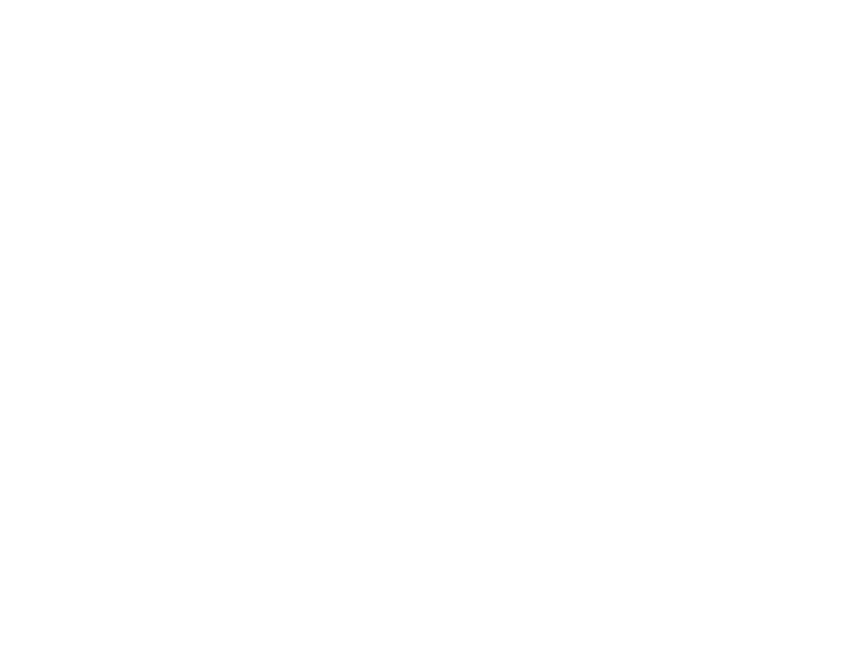

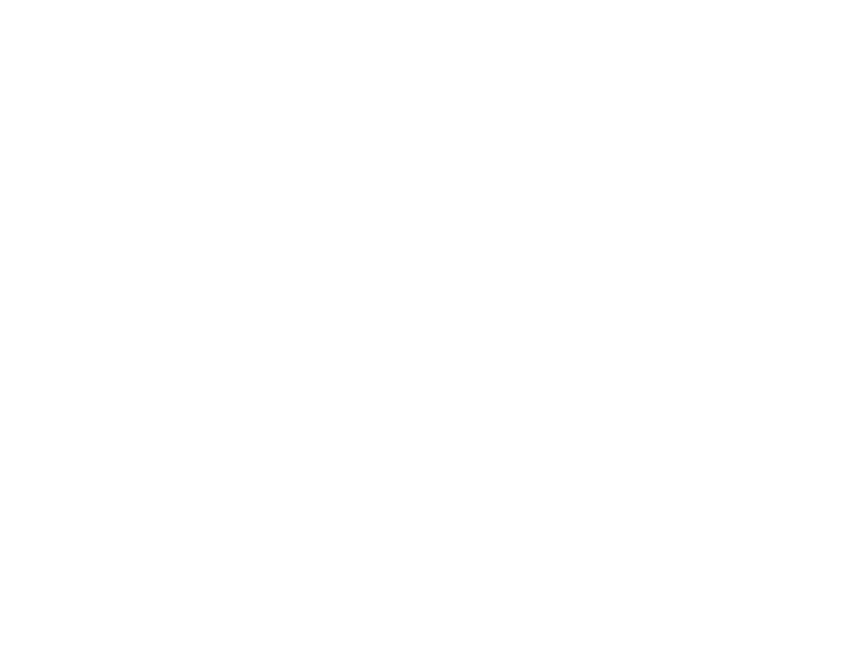

In [2]:
%matplotlib ipympl
Fig3 = Fig(num=3, grid=(4, 4), size=(8.5, 6.5), fontsize=6)  # size=(7.2, 5.3) if not scaling properly
print(Fig3.fig.get_size_inches())
Fig3stats = Fig(num="Figure 3 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=6) 
print(Fig3stats.fig.get_size_inches())
Fig3comb = FigMirror(Fig3, Fig3stats)

[8.5 6.5]
[8.5 6.5]


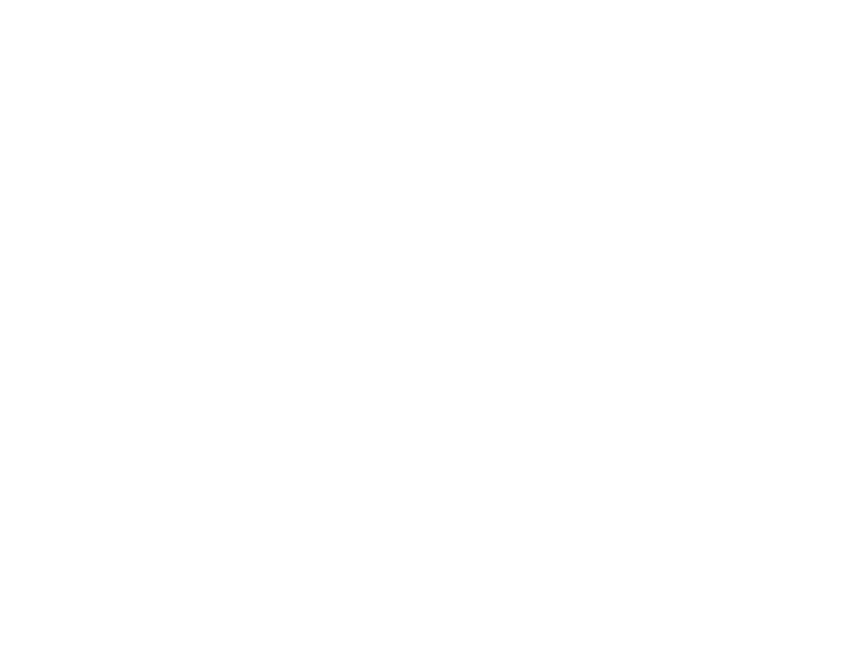

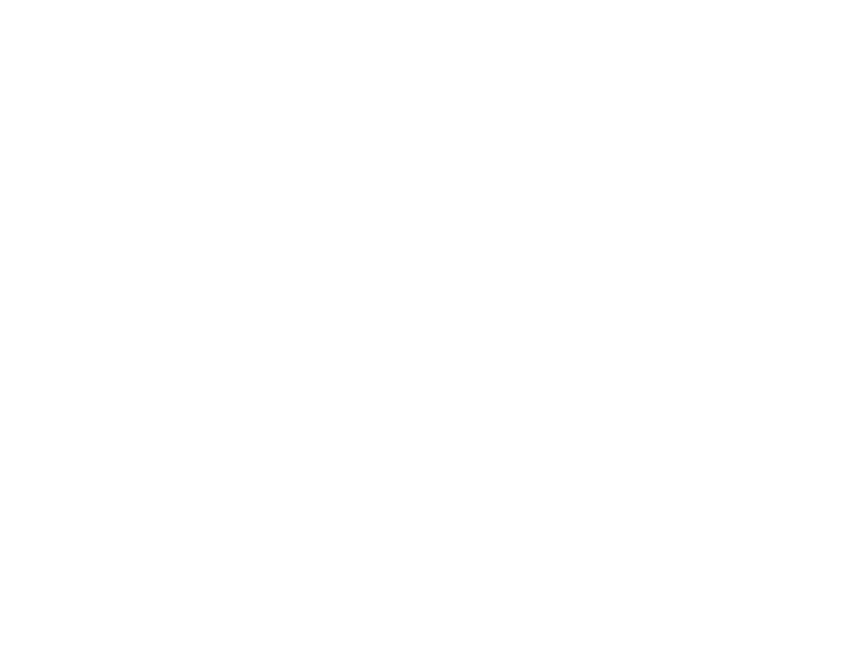

In [3]:
%matplotlib ipympl
FigS6 = Fig(num="S6", grid=(4, 4), size=(8.5, 6.5), fontsize=6)  # size=(7.2, 5.3) if not scaling properly
print(FigS6.fig.get_size_inches())
FigS6stats = Fig(num="Figure S6 stats", grid=(4, 4), size=(8.5, 6.5), fontsize=6) 
print(FigS6stats.fig.get_size_inches())
FigS6comb = FigMirror(FigS6, FigS6stats)

First, plot example freezing cells from Marble07: 53, 67, 90, and 334

In [4]:
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2])

<AxesSubplot:>

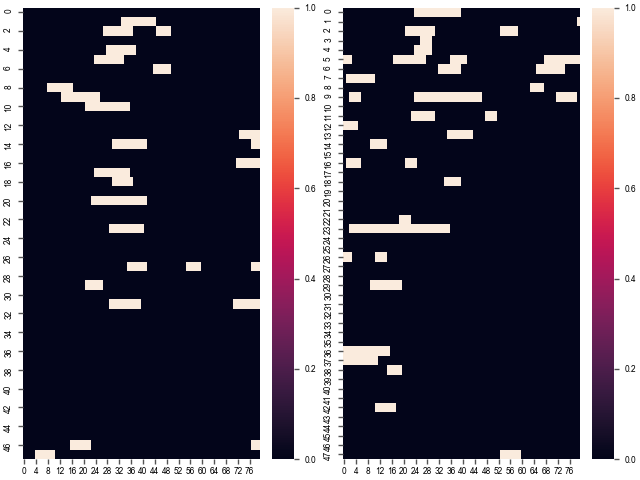

In [5]:
_, ax = plt.subplots(1, 2)
sns.heatmap(mmd.motion_tuning['Shock'][1].pe_rasters['freeze_onset'][334], ax=ax[0])
sns.heatmap(mmd.motion_tuning['Shock'][1].pe_rasters['freeze_onset'][53], ax=ax[1])

In [6]:
# fig, ax = plt.subplots()
# fig.set_size_inches([7.1 , 1.76])
ax_ex_cell_cofire = Fig3.subplot2grid(Fig3.gs[0, 0:3], grid=(1, 2), return_axes=True)
neurons_plot = [53, 334]
im_data = sio.loadmat(mmd.motion_tuning['Shock'][1].dir_use / 'FinalOutput.mat')
rawtraces = im_data['NeuronTraces']['RawTrace'].squeeze().item()
rawtraces = rawtraces[:, :mmd.motion_tuning['Shock'][1].PSAbool.shape[1]]  # Align rawtraces with PSAbool
rawz = (rawtraces - rawtraces.mean(axis=1)[:, None])/rawtraces.std(axis=1)[:, None]
psabool = mmd.motion_tuning['Shock'][1].PSAbool
t = np.arange(0, mmd.motion_tuning['Shock'][1].PSAbool.shape[1])/mmd.motion_tuning['Shock'][1].sr_image
for ax, xlim in zip(ax_ex_cell_cofire, ([265, 290], [340, 380])):
    for psa, trace in zip(psabool[[neurons_plot]].astype(bool), rawz[[neurons_plot]]):
        ax.plot(t, trace)
        for event_idx in contiguous_regions(psa):
            ax.plot(t[event_idx[0]:event_idx[1]], trace[event_idx[0]:event_idx[1]], 'r')

    for ftimes in mmd.motion_tuning['Shock'][1].freezing_times:
        ax.axvspan(ftimes[0], ftimes[1], color=[0, 1, 0, 0.3])

    ax.set_xlim(xlim)

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_27473/4045577380.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for psa, trace in zip(psabool[[neurons_plot]].astype(bool), rawz[[neurons_plot]]):
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_27473/4045577380.py:12: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  for psa, trace in zip(psabool[[neurons_plot]].astype(bool), rawz[[neurons_plot]]):


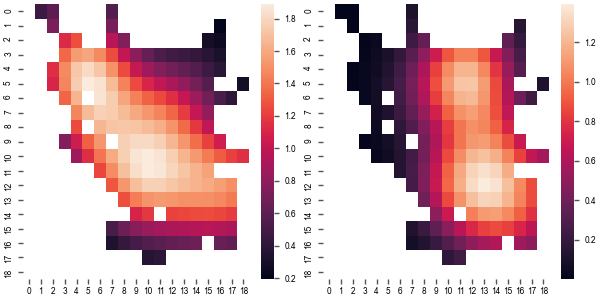

In [7]:
PF = pf.load_pf('Marble07', 'Shock', 1)
_, ax = plt.subplots(1, 2, figsize=(6, 3))
for a, nid in zip(ax, neurons_plot):
    sns.heatmap(PF.tmap_sm[nid], ax=a)

In [8]:
# Maybe better learner cell?
axlrncella, axlrncella_stats = Fig3comb.subplot2grid(Fig3.gs[1, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble07', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(334, base_day=1, base_arena='Shock', batch_map=False, 
                            plot_ROI=False, ax=axlrncella.squeeze(), label_fig=False)

Assembling neuron map for base_day=1 and base_arena=Shock
Cannot find normal map - trying to run in reverse
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  

array([<AxesSubplot:title={'center':'Shock Day -1\n Cell 508'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 341'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 334'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 16'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

In [9]:
# Example learner cell
axlrncellb, axlrncellb_stats = Fig3comb.subplot2grid(Fig3.gs[2, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble24', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(36, base_day=1, base_arena='Shock', batch_map=False,
                           plot_ROI=False, ax=axlrncellb.squeeze(), label_fig=False) # batch_map=True?

Assembling neuron map for base_day=1 and base_arena=Shock
Cannot find normal map - trying to run in reverse
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())


array([<AxesSubplot:>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 60'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 36'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 259'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

In [10]:
# Example unstable ANI cell
# Need to update this to look out +/- 2 sec due to different frame rate
axanicell, axanicell_stats = Fig3comb.subplot2grid(Fig3.gs[3, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble20', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(2, base_day=4, base_arena='Shock', batch_map=False,
                           plot_ROI=False, ax=axanicell.squeeze(), label_fig=False)

Assembling neuron map for base_day=4 and base_arena=Shock
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  

array([<AxesSubplot:title={'center':'Shock Day -1\n Cell 125'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 2'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 18'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 217'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

Supplemental cell plots

In [11]:
# Example freezing cells from Marble07: 53, 67, 90, and 334

In [12]:
# Marble 27 Shock day 4 cell 22

In [13]:
axlrncell2, axlrncell2_stats = FigS6comb.subplot2grid(FigS6.gs[3, 0:2], grid=(1, 4), return_axes=True)
mmd = fa.MotionTuningMultiDay('Marble27', arena = 'Shock', days= [-1, 4, 1, 2])
mmd.plot_raster_across_days(22, base_day=4, base_arena='Shock', batch_map=False,
                           plot_ROI=False, ax=axlrncell2.squeeze(), label_fig=False)

Assembling neuron map for base_day=4 and base_arena=Shock
Cannot find normal map - trying to run in reverse


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  ax.figure.draw(ax.figure.canvas.get_renderer())
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/matrix.py:332: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  

array([<AxesSubplot:title={'center':'Shock Day -1\n Cell 39'}, xlabel='Time from freeze_onset(s)', ylabel='freeze_onset #'>,
       <AxesSubplot:title={'center':'Shock Day 4\n Cell 22'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 1\n Cell 170'}, xlabel='Time from freeze_onset(s)'>,
       <AxesSubplot:title={'center':'Shock Day 2\n Cell 178'}, xlabel='Time from freeze_onset(s)'>],
      dtype=object)

Plot #1s: plot freeze-tuned cell rasters with motion-tuned cell rasters right below - are these specific freezing cells or more motion tuned cells?

Plot #2b: Proportion freeze-tuned across days

In [14]:
# First create dataframe with proportion tuned values
mice_groups = [err.learners, err.nonlearners, err.ani_mice_good]
day_list, arena_list, group_list, exp_group_list, prop_tuned_list, mouse_list = [], [], [], [], [], []
group_names = ['Learners', 'Nonlearners', 'ANI']
exp_group_names = ['Control', 'Control', 'ANI']
days = [-1, 4, 1, 2]
for arena in ['Open', 'Shock']:
    for group, exp_group_name, group_name in zip(mice_groups, exp_group_names, group_names):
        for mouse in group:
            mmd = fa.MotionTuningMultiDay(mouse, arena=arena, days=days)
            p_tuned = mmd.get_prop_tuned()
            group_list.extend([group_name]*len(p_tuned))
            exp_group_list.extend([exp_group_name]*len(p_tuned))
            day_list.extend(days)
            arena_list.extend([arena]*len(p_tuned))
            prop_tuned_list.extend(p_tuned)
            mouse_list.extend([mouse]*len(p_tuned))


df_prop = pd.DataFrame({'Exp Group': exp_group_list, 'Group': group_list, 'Mouse': mouse_list,
                            'Day': day_list, 'Arena': arena_list, 'Prop Tuned': prop_tuned_list})

/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble24/20181127_1_openfield: nbadpts = 10 max_in_a_row = 4
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38
/Users/nkinsky/Documents/BU/Working/Eraser/Control Group/Marble6/20180421_1_openfield: nbadpts = 63 max_in_a_row = 38


In [15]:
axprop, axprop_stats = Fig3comb.subplot(444)
sns.stripplot(data=df_prop[df_prop['Arena'] == 'Shock'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
              dodge=True, ax=axprop, order=days, size=3)
group_rows = df_prop['Group'].copy()  # This generates warnings about chained indexing for some reason
group_rows_ = ["_" + row for row in df_prop['Group']]
df_prop.loc[:, 'Group'] = group_rows_
sns.barplot(data=df_prop[df_prop['Arena'] == 'Shock'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
            dodge=True, ax=axprop, order=days)
axprop.legend(loc='upper right')
df_prop.loc[:, 'Group'] = group_rows

# sns.stripplot(data=df_prop, y='Prop Tuned', x='Day', hue='Mouse', palette='Set2', dodge=False, ax=ax[1], order=days)
# # sns.barplot(data=df_prop, y='Prop Tuned', x='Day', hue='Mouse', palette='Set2', dodge=False, ax=ax[1], order=days)
# sns.despine(fig=fig)
# ax[1].legend([])

In [16]:
axpropo, axpropo_stats = FigS6comb.subplot(444)
sns.stripplot(data=df_prop[df_prop['Arena'] == 'Open'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
              dodge=True, ax=axpropo, order=days, size=3)
group_rows = df_prop['Group'].copy()  # This generates warnings about chained indexing for some reason
group_rows_ = ["_" + row for row in df_prop['Group']]
df_prop.loc[:, 'Group'] = group_rows_
sns.barplot(data=df_prop[df_prop['Arena'] == 'Open'], y='Prop Tuned', x='Day', hue='Group', palette='Set2',
            dodge=True, ax=axpropo, order=days)
axpropo.legend(loc='upper right')
df_prop.loc[:, 'Group'] = group_rows

Plot #2bsup: Proportion freeze off-tuned across days

Plot #2c: Freeze-tuned cell firing stability across days is higher in learners than non-learners from 4 to 1-hour session

In [17]:
ax_frz_stab1, ax_frz_stab1_stats = Fig3comb.subplot(447)
ts = fa.TuningStability('Shock', 'freeze_onset', 0.01) # Load in tuningstability object

base_day = 1
metric_plot = 'event_rates'
delta=True
fig, ax = ts.plot_metric_stability_by_group(base_day=base_day, metric_plot=metric_plot, delta=delta, 
                                           ax=[ax_frz_stab1, ax_frz_stab1_stats], size=2, alpha=0.7, jitter=0.15)

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [18]:
ax_frz_stab4, ax_frz_stab4_stats = Fig3comb.subplot(448)
ts = fa.TuningStability('Shock', 'freeze_onset', 0.01) # Load in tuningstability object

base_day = 4
metric_plot = 'event_rates'
delta=True
fig, ax = ts.plot_metric_stability_by_group(base_day=base_day, metric_plot=metric_plot, delta=delta,
                                           ax=[ax_frz_stab4, ax_frz_stab4_stats], size=2, alpha=0.7, jitter=0.15)

/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Plot #3: Covariance matrix plot?

Plot #3a (Supplemental): Ensemble plots - show example of a couple ensembles that form and how they match freeze-cells.

Plot #4: Plot of %shock cells between groups across different epochs.

Plot #5: Plot of ANI effects on shock cell covariance and all cell covariance


In [100]:
from copy import deepcopy

def add_memory_designations(df_use, before=['-2_-1', '-1_4'], during=['4_1'], after=['1_2', '2_7']):
    """Add in designations for before, 4hr (during), and after ANI administration into your dataframe"""
    df = deepcopy(df_use)
    desig = ["" for a in df.itertuples()]
    
    def create_bool_array_from_list(bool_list):
        bool_out = False
        for b in bool_list:
            bool_out = np.bitwise_or(bool_out, b)
            
        return bool_out
    
    before_bool_list = [df["d1_d2"] == bef for bef in before]
    before_ind = np.where(create_bool_array_from_list(before_bool_list))[0]
    during_bool_list = [df["d1_d2"] == dur for dur in during]
    during_ind = np.where(create_bool_array_from_list(during_bool_list))[0]
    after_bool_list = [df["d1_d2"] == aft for aft in after]
    after_ind = np.where(create_bool_array_from_list(after_bool_list))[0]
    
       # Old hardcoded method below for reference/bug checking
#     before_ind = np.where((df["d1_d2"] == "-2_-1") | (df["d1_d2"] == "-1_4"))[0]
#     during_ind = np.where(df["d1_d2"] == "4_1")[0]
#     after_ind = np.where((df["d1_d2"] == "1_2") | (df["d1_d2"] == "2_7"))[0]
    for idd, d in enumerate(desig):
        if idd in before_ind:
            desig[idd] = "Before"
        elif idd in during_ind:
            desig[idd] = "4hr"
        elif idd in after_ind:
            desig[idd] = "After"

    df['Designation'] = desig
    
    return df

In [99]:
t = copy(sig4frz_dfreg)
tt = copy(sig4frz_dfreg)
tt.pop('Designation')
tt['Designation'] = copy(t['Designation'])
t['Designation'] = copy(tt['Designation'])

In [21]:
import scipy.stats as stats
def stats_before_after(df_use, key_use, ax=None, fontsize=None):
    """Compares mean covariances in a DataFrame. Pools days before (-2 and -1) and days after (1 and 2) shock + 
    injection. Compares across and within groups.
    :param reg: True = use reg_memory_designations, False = use regular memory degisnations"""
    
    df_before = df_use[df_use['Designation'] == 'Before']
    df_after = df_use[df_use['Designation'] == 'After']
    df4 = df_use[df_use['Designation'] == '4hr'] 
        
    stat_bef, p_bef = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_before[df_before['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_aft, p_aft = stats.ttest_ind(df_after[df_after['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_ctrl, p_ctrl = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_ani, p_ani = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_dur, p_dur = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use],
                                     df4[df4['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_b4c, p_b4c = stats.ttest_ind(df_before[df_before['Group'] == 'Ctrl'][key_use],
                                      df4[df4['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_b4a, p_b4a = stats.ttest_ind(df_before[df_before['Group'] == 'ANI'][key_use],
                                      df4[df4['Group'] == 'ANI'][key_use], nan_policy='omit')
    stat_4ac, p_4ac = stats.ttest_ind(df4[df4['Group'] == 'Ctrl'][key_use], 
                                     df_after[df_after['Group'] == 'Ctrl'][key_use], nan_policy='omit')
    stat_4aa, p_4aa = stats.ttest_ind(df4[df4['Group'] == 'ANI'][key_use], 
                                     df_after[df_after['Group'] == 'ANI'][key_use], nan_policy='omit')
    
    if ax is None:  # Print to screen
        print(f'p={p_bef:0.3g} baseline b/w groups')
        print(f'p={p_aft:0.3g} day 1-2 b/w groups')
        print(f'p={p_ctrl:0.3g} before-after Ctrl')
        print(f'p={p_ani:0.3g} before-after ANI')
        print(f'p={p_dur:0.3g} 4 hrs b/w groups')
    else:  # Print into specified axes
        if fontsize is None:
            fsize = 12.0
        else:
            fsize = 4.0
        ax.text(0.1, 0.9, f'p={p_4aa:0.3g} 4 hr v after ANI', fontsize=fsize)
        ax.text(0.1, 0.8, f'p={p_4ac:0.3g} 4 hr v after Ctrl', fontsize=fsize)
        ax.text(0.1, 0.7, f'p={p_b4a:0.3g} before v 4 hr ANI', fontsize=fsize)
        ax.text(0.1, 0.6, f'p={p_b4c:0.3g} before v 4 hr Ctrl', fontsize=fsize)
        ax.text(0.1, 0.5, f'p={p_bef:0.3g} baseline b/w groups', fontsize=fsize)
        ax.text(0.1, 0.4, f'p={p_aft:0.3g} day 1-2 b/w groups', fontsize=fsize)
        ax.text(0.1, 0.3, f'p={p_ctrl:0.3g} before-after Ctrl', fontsize=fsize)
        ax.text(0.1, 0.2, f'p={p_ani:0.3g} before-after ANI', fontsize=fsize)
        ax.text(0.1, 0.1, f'p={p_dur:0.3g} 4 hrs b/w groups', fontsize=fsize)

In [22]:
bin_size = 0.5 # sec
all_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='all', keep_silent=True)
freeze_silent_cov = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', arena2='Shock',
                                               neurons='freeze_onset', keep_silent=True)

# Now aadd in columns and reorganize a bit
sigz_freeze_df = cova.cov_dict_to_df(freeze_silent_cov, baseline_dict_use=all_cov, include_silent=True)
sigz_freeze_df = add_memory_designations(sigz_freeze_df)

sigz_all_df = cova.cov_dict_to_df(all_cov, baseline_dict_use=all_cov, include_silent=True)
sigz_all_df = add_memory_designations(sigz_all_df)



Marble07: 5it [00:03,  1.35it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:04,  1.34it/s]
Marble12: 5it [00:03,  1.57it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:03,  1.57it/s]
Marble24: 5it [00:03,  1.53it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:03,  1.56it/s]
Marble27: 5it [00:03,  1.47it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:04,  1.47it/s]
Marble06: 4it [00:02,  1.47it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:05,  1.04it/s]
Marble11: 5it [00:04,  1.09it/s]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:05,  1.09it/s]
Marble29: 5it [00:03,  1.46it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:04,  1.46it/s]
Marble17: 5it [00:04,  1.22it/s]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:04,  1.24it/s]
Marble18: 5it [00:03,  1.59it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:03,  1.61it/s]
Marble19: 5it [00:03,  1.41it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:04,  1.42it/s]
Marble20: 5it [00:03,  1.54it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:03,  1.57it/s]
Marble25: 5it [00:03,  1.40it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:04,  1.40it/s]
Marble07: 4it [00:04,  1.00it/s]

No tunings found for Marble07 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble07: 6it [00:06,  1.00s/it]
Marble12: 4it [00:03,  1.17it/s]

No tunings found for Marble12 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble12: 6it [00:05,  1.16it/s]
Marble24: 4it [00:03,  1.15it/s]

No tunings found for Marble24 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble24: 6it [00:05,  1.14it/s]
Marble27: 4it [00:03,  1.13it/s]

No tunings found for Marble27 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble27: 6it [00:05,  1.13it/s]
Marble06: 4it [00:03,  1.10it/s]

No position data found for Marble06 Shock day 7, loading neural data only


Marble06: 6it [00:07,  1.18s/it]
Marble11: 4it [00:04,  1.20s/it]

No tunings found for Marble11 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble11: 6it [00:07,  1.20s/it]
Marble29: 4it [00:03,  1.08it/s]

No tunings found for Marble29 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble29: 6it [00:05,  1.08it/s]
Marble17: 4it [00:04,  1.09s/it]

No tunings found for Marble17 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble17: 6it [00:06,  1.08s/it]
Marble18: 4it [00:03,  1.21it/s]

No tunings found for Marble18 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble18: 6it [00:05,  1.18it/s]
Marble19: 4it [00:03,  1.07it/s]

No tunings found for Marble19 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble19: 6it [00:05,  1.06it/s]
Marble20: 4it [00:03,  1.20it/s]

No tunings found for Marble20 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble20: 6it [00:05,  1.20it/s]
Marble25: 4it [00:03,  1.06it/s]

No tunings found for Marble25 Shock day 7: run .get_tuning_sig() and .save_sig_tuning()


Marble25: 6it [00:05,  1.05it/s]


## NRK todo: clean this up and/or add to modules in Git repo or change to use pingouin for stats!

In [135]:
import eraser_reference as err
from copy import copy
def add_in_subject_id(df):
    """Add in mouse ids to dataframe so that you can run mixed anovas. Notebook specific function."""
    df_wid = copy(df)
    mouse_names_use = []
    for names in [err.learners, err.nonlearners, err.ani_mice_good]:
        mouse_names_use.extend(names)
    mouse_id_list = []
    for mid, mname in enumerate(mouse_names_use):
        mouse_id_list.extend([mid]*len(df['d1_d2'].unique()))
    df_wid['Mouse'] = mouse_id_list
    
    return df_wid

In [185]:
ax_sigfrz_cov, ax_sigfrz_cov_stats = Fig3comb.subplot(Fig3.gs[2, 2])
ax_sigall_cov, ax_sigall_cov_stats = Fig3comb.subplot(Fig3.gs[2, 3])

sigz_freeze_df = add_in_subject_id(sigz_freeze_df)
sigz_all_df = add_in_subject_id(sigz_all_df)

cmap_use = plt.get_cmap('Set2').colors[0:3:2]  # Use consistent colormap

for a, astat, title_use, df_use in zip([ax_sigfrz_cov, ax_sigall_cov], [ax_sigfrz_cov_stats, ax_sigall_cov_stats],
                                       ['Freeze Cell Covariance', 'All Cell Covariance'], 
                                       [sigz_freeze_df, sigz_all_df]):
    # Plot data
    gfg = sns.stripplot(x="Designation", y="cov_z_mean", hue="Group", size=3, palette=cmap_use,
                  data=df_use[~(df_use['Designation'] == '')], dodge=True, ax=a)
    gfg.legend(fontsize=6, markerscale=0.15)
    a.set_title(title_use, fontsize=8)
    a.set_ylabel(r'$\mathregular{\overline{Z}}$', fontsize=8)
    a.set_xlabel('', fontsize=8)
    a.tick_params(axis='both', which='major', labelsize=8, grid_linewidth=1)
    plt.setp(a.spines.values(), linewidth=1)
    sns.despine(ax=a)
    
    # Calculate and plot stats
    stats_before_after(df_use, 'cov_z_mean', ax=astat, fontsize=6)
#     stats_sig = pg.mixed_anova(data=df_use[~(df_use['Designation'] == '')], 
#                                dv='cov_z_mean', within='Designation', between='Group', subject='Mouse')
#     pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
#                                within='Designation', between='Group', subject='Mouse', parametric=False, 
#                                within_first=True)
    stats_sig = pg.anova(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
                         between=['Designation', 'Group'])
#     pw_sig = pg.pairwise_tukey(data=df_use[~(df_use['Designation'] == '')], dv='cov_z_mean', 
#                          between='Designation')
    pw_sig = pg.pairwise_tests(data=df_use[~(df_use['Designation'] == '')], padjust='bonf', dv='cov_z_mean', 
                               between=['Group', 'Designation'], parametric=False)
    astat.set_title(title_use)
    astat.text(0.1, 0.9, str(stats_sig), fontdict={'fontsize': 6})
    astat.text(0.1, 0.6, str(pw_sig), fontdict={'fontsize': 6})
    sns.despine(ax=astat, bottom=True, left=True)
    astat.tick_params(axis='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    
    print(stats_sig)
    print(pw_sig)
#     print(pw_sig2)

                Source        SS    DF        MS         F     p-unc       np2
0          Designation  1.108582   2.0  0.554291  4.497697  0.015606  0.142794
1                Group  0.273644   1.0  0.273644  2.220438  0.142013  0.039495
2  Designation * Group  0.344494   2.0  0.172247  1.397666  0.255971  0.049218
3             Residual  6.654899  54.0  0.123239       NaN       NaN       NaN
              Contrast Group      A       B Paired  Parametric  U-val  \
0                Group     -    ANI    Ctrl  False       False  326.0   
1          Designation     -    4hr   After  False       False  161.0   
2          Designation     -    4hr  Before  False       False  220.0   
3          Designation     -  After  Before  False       False  462.0   
4  Group * Designation   ANI    4hr   After  False       False   34.0   
5  Group * Designation   ANI    4hr  Before  False       False   39.0   
6  Group * Designation   ANI  After  Before  False       False   76.0   
7  Group * Designatio

Plot #7: ANI effects on place-cell covariance? Look at only top cells maybe? Or look at just cells with high covariance on days -2/-1? Might expect it to stay high for ANI and get much reduced for others.  This is above and beyond the correlation metric because it looks at how cells fire together across the whole session, not just whether they happen to fire in the same spot.

In [28]:
# Create dataframe to track cell covariance across days
sig4frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
sig1frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)
sig2frz_cov_dict = cova.group_cov_across_days(bin_size=bin_size, arena1='Shock', neurons='freeze_onset',
                                              arena2='Shock', base_days=[2, 2, 2, 2, 2],
                                              reg_days=[-2, -1, 4, 1, 2], keep_silent=False)

# Clean up and reshape dataframe
sig4frz_dfreg = cova.cov_dict_to_df(sig4frz_cov_dict, all_cov, register=True)
sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])

sig1frz_dfreg = cova.cov_dict_to_df(sig1frz_cov_dict, all_cov, register=True)
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])

sig2frz_dfreg = cova.cov_dict_to_df(sig2frz_cov_dict, all_cov, register=True)
sig2frz_dfreg = add_memory_designations(sig2frz_dfreg, before=['2_-2', '2_-1'], during=['2_4'], after=['2_1', '2_2'])

Marble07: 5it [00:05,  1.05s/it]
Marble12: 5it [00:04,  1.18it/s]
Marble24: 5it [00:04,  1.13it/s]
Marble27: 5it [00:04,  1.13it/s]
Marble06: 5it [00:04,  1.12it/s]
Marble11: 5it [00:05,  1.19s/it]
Marble29: 5it [00:04,  1.09it/s]
Marble17: 5it [00:05,  1.05s/it]
Marble18: 5it [00:04,  1.22it/s]
Marble19: 5it [00:04,  1.08it/s]
Marble20: 5it [00:04,  1.20it/s]
Marble25: 5it [00:04,  1.08it/s]
Marble07: 5it [00:04,  1.01it/s]
Marble12: 5it [00:04,  1.15it/s]
Marble24: 5it [00:04,  1.11it/s]
Marble27: 5it [00:04,  1.14it/s]
Marble06: 5it [00:04,  1.04it/s]
Marble11: 5it [00:06,  1.24s/it]
Marble29: 5it [00:04,  1.06it/s]
Marble17: 5it [00:05,  1.05s/it]
Marble18: 5it [00:04,  1.20it/s]
Marble19: 5it [00:04,  1.07it/s]
Marble20: 5it [00:04,  1.19it/s]
Marble25: 5it [00:04,  1.06it/s]
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nkinsky/minicon

In [118]:
sig4frz_dfreg = add_memory_designations(sig4frz_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
sig4frz_dfreg = add_in_subject_id(sig4frz_dfreg)
stats4reg = pg.mixed_anova(data=sig4frz_dfreg[np.bitwise_not(np.isnan(sig4frz_dfreg['cov_z_mean']))], 
                           dv='cov_z_mean', within='Designation', between='Group', subject='Mouse')
pw4reg = pg.pairwise_tests(data=sig4frz_dfreg[np.bitwise_not(np.isnan(sig4frz_dfreg['cov_z_mean']))], padjust='bonf',
                           dv='cov_z_mean', within='Designation', between='Group', subject='Mouse', parametric=False,
                           within_first=True)
print(stats4reg)
print(pw4reg)

        Source        SS  DF1  DF2        MS         F     p-unc       np2  \
0        Group  0.526960    1    9  0.526960  1.165685  0.308372  0.114669   
1  Designation  2.637457    2   18  1.318728  4.671602  0.023217  0.341701   
2  Interaction  0.761780    2   18  0.380890  1.349305  0.284434  0.130376   

        eps  
0       NaN  
1  0.812165  
2       NaN  
              Contrast Designation      A       B Paired  Parametric  U-val  \
0          Designation           -    4hr   After   True       False    NaN   
1          Designation           -    4hr  Before   True       False    NaN   
2          Designation           -  After  Before   True       False    NaN   
3                Group           -    ANI    Ctrl  False       False   20.0   
4  Designation * Group         4hr    ANI    Ctrl  False       False   22.0   
5  Designation * Group       After    ANI    Ctrl  False       False   15.0   
6  Designation * Group      Before    ANI    Ctrl  False       False    8.0   

In [119]:
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])
sig1frz_dfreg = add_in_subject_id(sig1frz_dfreg)
stats1reg = pg.mixed_anova(data=sig1frz_dfreg[np.bitwise_and(np.bitwise_not(np.isnan(sig1frz_dfreg['cov_z_mean'])), 
                                                             sig1frz_dfreg['Designation'] != "")], 
                           dv='cov_z_mean', within='Designation', between='Group', subject='Mouse')
pw1reg = pg.pairwise_tests(data=sig1frz_dfreg[np.bitwise_and(np.bitwise_not(np.isnan(sig1frz_dfreg['cov_z_mean'])), 
                                                             sig1frz_dfreg['Designation'] != "")], padjust='bonf',
                           dv='cov_z_mean', within='Designation', between='Group', subject='Mouse', 
                           parametric=False, within_first=True)
print(stats1reg)
print(pw1reg)

        Source        SS  DF1  DF2        MS         F     p-unc  p-GG-corr  \
0        Group  0.009039    1    9  0.009039  0.184528  0.677611        NaN   
1  Designation  0.226357    2   18  0.113179  1.851320  0.185712   0.219291   
2  Interaction  0.223649    2   18  0.111825  1.829169  0.189159        NaN   

        np2       eps sphericity   W-spher   p-spher  
0  0.020091       NaN        NaN       NaN       NaN  
1  0.170608  0.592317      False  0.311715  0.005271  
2  0.168911       NaN        NaN       NaN       NaN  
              Contrast Designation      A       B Paired  Parametric  U-val  \
0          Designation           -    4hr   After   True       False    NaN   
1          Designation           -    4hr  Before   True       False    NaN   
2          Designation           -  After  Before   True       False    NaN   
3                Group           -    ANI    Ctrl  False       False   16.0   
4  Designation * Group         4hr    ANI    Ctrl  False       False

In [137]:
areg4, areg4stats = Fig3comb.subplot(Fig3.gs[3, 2])
areg1, areg1stats = Fig3comb.subplot(Fig3.gs[3, 3])

for df_use, ap, astat, title_use in zip([sig4frz_dfreg, sig1frz_dfreg], [areg4, areg1], 
                                        [areg4stats, areg1stats], ['4 hr. frz cells - tracked across sessions', 
                                                                   '1 day frz cells - Tracked across sessions']):
    # Plot data
    sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use, dodge=True, ax=ap, size=3,
                  palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.mixed_anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], 
                               dv='cov_z_mean', within='Designation', between='Group', subject='Mouse')
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', within='Designation', between='Group', subject='Mouse', 
                               parametric=False, within_first=True)
    astat.set_title(title_use)
    astat.text(0.1, 0.9, str(stats_reg), fontdict={'fontsize': 6})
    astat.text(0.1, 0.6, str(pw_reg), fontdict={'fontsize': 6})


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 35.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/Users/nkinsky/miniconda3/envs/eraser/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


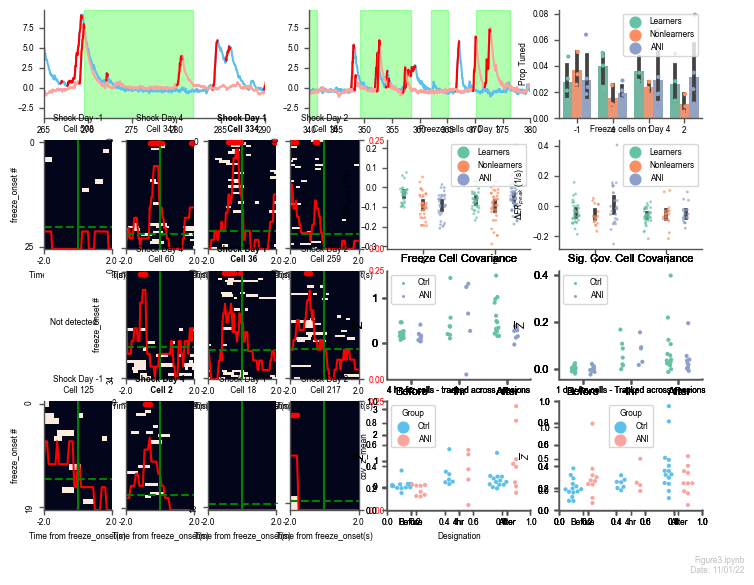

In [144]:
Fig3.fig

In [153]:
sig4_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                              arena2='Shock', base_days=[4, 4, 4, 4, 4],
                                              reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                              keep_silent=False)
sig4_dfreg = cova.cov_dict_to_df(sig4_cov_dict, all_cov, register=True)
sig1_cov_dict = cova.group_sig_cov_across_days(bin_size=bin_size, arena1='Shock',
                                              arena2='Shock', base_days=[1, 1, 1, 1, 1],
                                              reg_days=[-2, -1, 4, 1, 2], thresh=2,
                                              keep_silent=False)
sig1_dfreg = cova.cov_dict_to_df(sig1_cov_dict, all_cov, register=True)
sig1frz_dfreg = add_memory_designations(sig1frz_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_1', '1_2'])

Marble07: 5it [00:03,  1.37it/s]
Marble12: 5it [00:03,  1.61it/s]
Marble24: 5it [00:03,  1.62it/s]
Marble27: 5it [00:03,  1.54it/s]
Marble06: 5it [00:03,  1.49it/s]
Marble11: 5it [00:04,  1.10it/s]
Marble29: 5it [00:03,  1.49it/s]
Marble17: 5it [00:03,  1.29it/s]
Marble18: 5it [00:03,  1.65it/s]
Marble19: 5it [00:03,  1.50it/s]
Marble20: 5it [00:03,  1.65it/s]
Marble25: 5it [00:03,  1.49it/s]
Marble07: 5it [00:03,  1.38it/s]
Marble12: 5it [00:03,  1.60it/s]
Marble24: 5it [00:03,  1.56it/s]
Marble27: 5it [00:03,  1.54it/s]
Marble06: 5it [00:03,  1.51it/s]
Marble11: 5it [00:04,  1.09it/s]
Marble29: 5it [00:03,  1.47it/s]
Marble17: 5it [00:03,  1.27it/s]
Marble18: 5it [00:03,  1.64it/s]
Marble19: 5it [00:03,  1.45it/s]
Marble20: 5it [00:03,  1.62it/s]
Marble25: 5it [00:03,  1.34it/s]


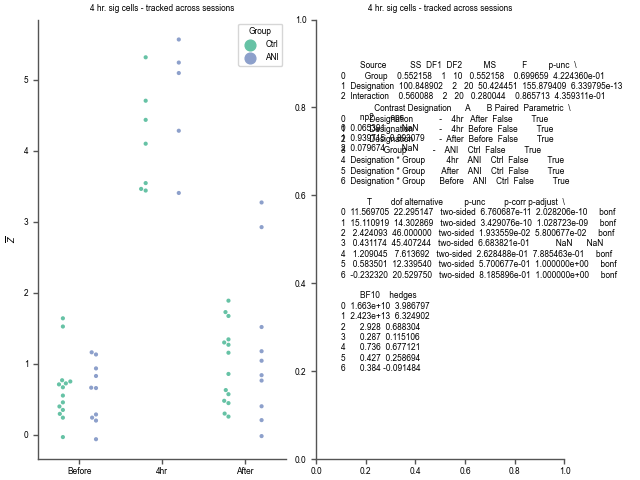

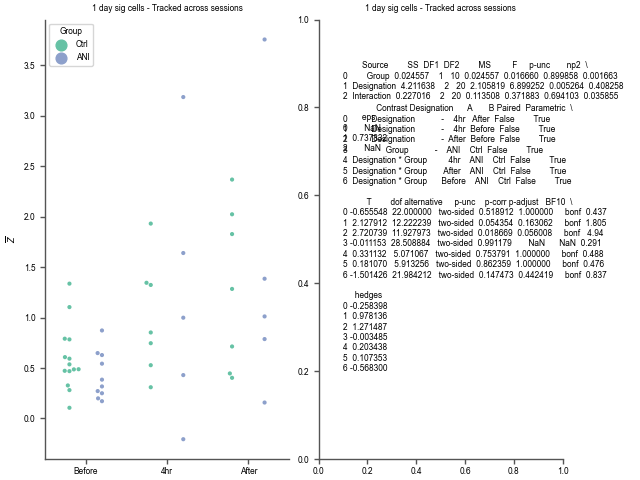

In [169]:
sig4_dfreg = add_memory_designations(sig4_dfreg, before=['4_-2', '4_-1'], during=['4_4'], after=['4_1', '4_2'])
sig4_dfreg = add_in_subject_id(sig4_dfreg)
sig1_dfreg = add_memory_designations(sig1_dfreg, before=['1_-2', '1_-1'], during=['1_4'], after=['1_2'])
sig1_dfreg = add_in_subject_id(sig1_dfreg)

fig4, ax4 = plt.subplots(1, 2)
fig1, ax1 = plt.subplots(1, 2)

for df_use, ap, astat, title_use in zip([sig4_dfreg, sig1_dfreg], [ax4[0], ax1[0]], 
                                        [ax4[1], ax1[1]], ['4 hr. sig cells - tracked across sessions', 
                                                          '1 day sig cells - Tracked across sessions']):
    # Plot data
    sns.swarmplot(x="Designation", y="cov_z_mean", hue="Group", data=df_use[df_use['Designation'] != ""], dodge=True, ax=ap, size=3, 
                  palette=cmap_use)
    ap.set_title(title_use)
    ap.set_xlabel('')
    ap.set_ylabel(r'$\overline{Z}$')
    
    # Calc and plot stats
    stats_reg = pg.mixed_anova(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], 
                               dv='cov_z_mean', within='Designation', between='Group', subject='Mouse')
    pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
                                                          df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', within='Designation', between='Group', subject='Mouse', 
                               parametric=False, within_first=True)
#     pw_reg = pg.pairwise_tests(data=df_use[np.bitwise_and(np.bitwise_not(np.isnan(df_use['cov_z_mean'])), 
#                                                           df_use['Designation'] != "")], padjust='bonf',
                               dv='cov_z_mean', between=['Designation', 'Group'], parametric=True, within_first=True)
    astat.set_title(title_use)
    astat.text(0.1, 0.7, str(stats_reg), fontdict={'fontsize': 6})
    astat.text(0.1, 0.2, str(pw_reg), fontdict={'fontsize': 6})

In [155]:
sig1_dfreg

,d1_d2,Group,cov_z_mean,Designation
0,1_-2,Ctrl,0.592693,Before
1,1_-1,Ctrl,0.487953,Before
2,1_4,Ctrl,0.527795,4hr
3,1_1,Ctrl,3.728253,
4,1_2,Ctrl,0.713442,After
5,1_-2,Ctrl,0.486279,Before
6,1_-1,Ctrl,0.783470,Before
7,1_4,Ctrl,0.852097,4hr
8,1_1,Ctrl,3.818555,
9,1_2,Ctrl,0.402716,After


### NRK todos!
1) Fix all above to NOT use mixed anova AND fix anything in Figure 2 that might use the same methodology.  Seems to be improperly accounting for multiple "Before" and "After" entries for the same mouse - is it just ignoring one or eliminating one? Tough to tell.  Figure this out

2) Look at covariance of all sig place fields on day -1, 4 hr, and day 1 and track covariance across days.

3) Make sure any increases we see in ANI mice aren't due to learning on day -1. Assess this by tracking OPEN field cells from day -2 to day 0 in the same manner as you look at other cells (e.g. All cells covariance plot). If we see an increase from days -2/-1 to day 0 that would mean something is being consolidated after day -1 and could explain why we see some increases in ANI mice covariance in the days following ANI administration.

### Last set of plots - Sig Cov cell tracking across days!

In [27]:
plot_path = Path('/Users/nkinsky/Documents/BU/Working/Eraser/plots')
Fig3.savefig(plot_path / 'Figure3.pdf', scriptname='Figure3.ipynb')
Fig3stats.savefig(plot_path / 'Figure3stats.pdf', scriptname='Figure3.ipynb')

/Users/nkinsky/Documents/BU/GitHub/Eraser/plotting.py:257: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig(filename, dpi=dpi, backend="pdf")
